In [1]:
import duckdb
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

In [2]:
df_deals_raw = pd.read_csv('/Users/guywinfield/PycharmProjects/Data/Octopus Legacy/deals.csv')
df_line_items_raw = pd.read_csv('/Users/guywinfield/PycharmProjects/Data/Octopus Legacy/deal_line_items.csv')

# Deals Deep Dive

In [3]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

WITH base AS (
    SELECT
        * EXCLUDE (deal_created_at, current_deal_stage_entered_at, scheduled_appointment_date, lead_city),

        CASE
            WHEN deal_created_at LIKE '__-__-____'
                THEN STRPTIME(deal_created_at, '%d-%m-%Y')
            ELSE STRPTIME(deal_created_at, '%Y-%m-%d')
        END AS deal_created_at,

        CASE
            WHEN current_deal_stage_entered_at LIKE '__-__-____'
                THEN STRPTIME(current_deal_stage_entered_at, '%d-%m-%Y')
            ELSE STRPTIME(current_deal_stage_entered_at, '%Y-%m-%d')
        END AS current_deal_stage_entered_at,

        CASE
            WHEN scheduled_appointment_date LIKE '__-__-____'
                THEN STRPTIME(scheduled_appointment_date, '%d-%m-%Y')
            ELSE STRPTIME(scheduled_appointment_date, '%Y-%m-%d')
        END AS scheduled_appointment_date,

        CASE
            WHEN current_deal_stage = 'NEW' THEN 1
            WHEN current_deal_stage = 'Appointment Scheduled' THEN 2
            WHEN current_deal_stage = 'Appointment Sat' THEN 3
            WHEN current_deal_stage = 'Preparing Documents' THEN 4
            WHEN current_deal_stage = 'Closed Lost' THEN 5
            WHEN current_deal_stage = 'Closed Won' THEN 6
            ELSE NULL
        END AS deal_order,

        CASE
            WHEN LOWER(lead_city) = 'brimingham' THEN 'Birmingham'
            WHEN LOWER(lead_city) = 'londun' THEN 'London'
            ELSE UPPER(LEFT(lead_city, 1)) || LOWER(SUBSTR(lead_city, 2))
        END AS lead_city,

    FROM df_deals_raw
)

SELECT
    *,
    DATEDIFF('day', deal_created_at, current_deal_stage_entered_at) AS days_diff_created_to_entered,
    DATEDIFF('day', scheduled_appointment_date, current_deal_stage_entered_at ) AS days_diff_entered_to_appointment

FROM base


"""

df_deals = con.execute(query).fetchdf()
df_deals.head(10)


,deal_id,contact_id,current_deal_stage,lead_source,deal_created_at,current_deal_stage_entered_at,scheduled_appointment_date,deal_order,lead_city,days_diff_created_to_entered,days_diff_entered_to_appointment
0,523892,200394,Closed Won,PPC,2025-10-13,2025-10-28,2025-10-23,6,London,15,5
1,523893,200539,Closed Lost,Organic,2025-09-14,2025-10-20,2026-01-20,5,London,36,-92
2,523894,201300,Closed Lost,Charity,2025-08-23,2025-09-08,2026-01-18,5,London,16,-132
3,523895,200233,Appointment Sat,Organic,2025-10-20,2025-10-27,2025-10-22,3,London,7,5
4,523896,200050,NEW,PPC,2025-10-04,2025-10-05,NaT,1,Leeds,1,<NA>
5,523897,200222,Preparing Documents,Charity,2025-10-26,2025-10-28,NaT,4,Cardiff,2,<NA>
6,523898,200355,Appointment Scheduled,Charity,2025-09-04,2025-09-07,NaT,2,Newcastle,3,<NA>
7,523899,200989,NEW,PPC,2025-10-17,2025-10-20,NaT,1,Newcastle,3,<NA>
8,523900,200166,Appointment Scheduled,PPC,2025-10-16,2025-10-19,NaT,2,Birmingham,3,<NA>
9,523901,201080,Closed Won,PPC,2025-07-01,2025-08-19,2025-10-07,6,Manchester,49,-49


In [4]:
df_deals.dtypes

deal_id                                      int64
contact_id                                   int64
current_deal_stage                          object
lead_source                                 object
deal_created_at                     datetime64[us]
current_deal_stage_entered_at       datetime64[us]
scheduled_appointment_date          datetime64[us]
deal_order                                   int32
lead_city                                   object
days_diff_created_to_entered                 int64
days_diff_entered_to_appointment             Int64
dtype: object

In [5]:
cols = ['deal_created_at','current_deal_stage_entered_at','scheduled_appointment_date']

for col in cols:
    df_deals[col] = df_deals[col].dt.date


In [6]:
df_deals["current_deal_stage"] = pd.Categorical(
    df_deals["current_deal_stage"],
    categories=["NEW", "Appointment Scheduled", "Appointment Sat", "Preparing Documents", "Closed Lost","Closed Won"],
    ordered=True,
)

In [7]:
df_deals.isna().sum()

deal_id                               0
contact_id                            0
current_deal_stage                    0
lead_source                           0
deal_created_at                       0
current_deal_stage_entered_at         0
scheduled_appointment_date          332
deal_order                            0
lead_city                             0
days_diff_created_to_entered          0
days_diff_entered_to_appointment    332
dtype: int64

In [8]:
df_deals.duplicated().sum()

np.int64(0)

In [9]:
df_deals.describe().T

,count,mean,std,min,25%,50%,75%,max
deal_id,1500.0,524641.5,433.157015,523892.0,524266.75,524641.5,525016.25,525391.0
contact_id,1500.0,200711.282,412.838274,200000.0,200354.75,200707.0,201068.25,201428.0
deal_order,1500.0,3.12,1.611417,1.0,2.0,2.0,5.0,6.0
days_diff_created_to_entered,1500.0,14.319333,13.311079,0.0,4.0,10.0,20.0,56.0
days_diff_entered_to_appointment,1168.0,-52.902397,60.99261,-231.0,-98.0,-36.5,-1.0,63.0


### ℹ : Fuzzy Matching for Scale

This dataset is pretty small so we can work around poor data quality with a CASE statement to clean the `lead_city`. If this was a model at much larger scale we could consider using Fuzzy Match which uses Levenshtein Distance to find near matches and clean them to the closest matching city.

It's much more scalable and saves a lot of time. But for this task I'll just clean up this city data and it's a bit excessive to import a whole UK city dataset just to clean 'brimingham' and 'londun'


In [10]:
check_cols = df_deals[['current_deal_stage','lead_source','lead_city']]

for col in check_cols.columns:
    print(check_cols[col].value_counts())

current_deal_stage
Appointment Scheduled    643
Closed Lost              243
Preparing Documents      221
NEW                      173
Closed Won               154
Appointment Sat           66
Name: count, dtype: int64
lead_source
Charity       660
PPC           486
Organic       226
Referral      104
Affiliates     24
Name: count, dtype: int64
lead_city
London         751
Manchester     138
Newcastle      132
Birmingham     127
Cardiff        123
Southampton    115
Leeds          114
Name: count, dtype: int64


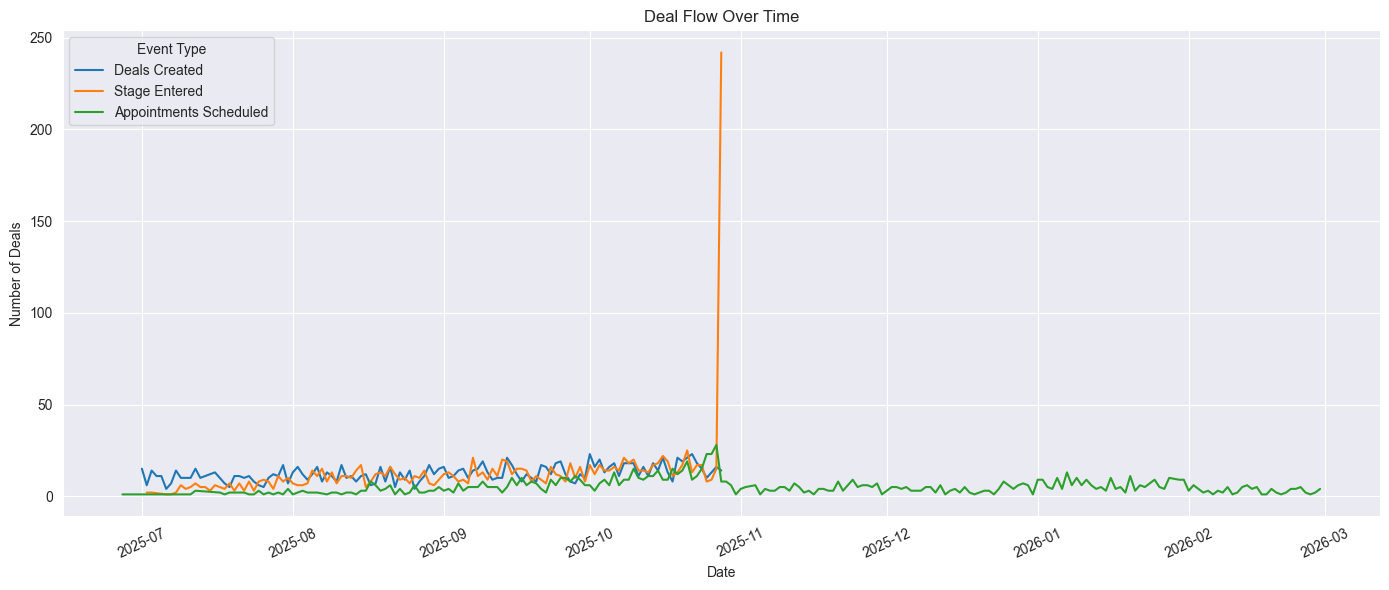

In [11]:
plt.figure(figsize=(14, 6))

sns.lineplot(x='deal_created_at', y='count', label='Deals Created', data= df_deals.groupby('deal_created_at').size().reset_index(name='count'))
sns.lineplot(x='current_deal_stage_entered_at', y='count', label='Stage Entered', data=df_deals.groupby('current_deal_stage_entered_at').size().reset_index(name='count'))
sns.lineplot(x='scheduled_appointment_date', y='count', label='Appointments Scheduled', data=df_deals.groupby('scheduled_appointment_date').size().reset_index(name='count'))


plt.xticks(rotation=25)
plt.xlabel('Date')
plt.ylabel('Number of Deals')
plt.title('Deal Flow Over Time')
plt.legend(title='Event Type', loc='upper left')
plt.tight_layout()
plt.show()


plt.show()

### 🚨 We have some data quality issues for the `current_deal_stage_entered_at` field.

This looks to be more systemic than user driven so we'll put these specific deals into a separate dataframe so that we can approach explore separately. We'll check our events data first to see whether this is an error from engineering or a bug in our staging models.


In [12]:
df_error = df_deals[df_deals['current_deal_stage_entered_at'] == '2025-10-28']

In [13]:
df_deals.loc[df_deals["current_deal_stage_entered_at"] == "2025-10-28", "current_deal_stage_entered_at"] = None

In [14]:
# df_deals.to_excel("df_deals.xlsx",sheet_name='df_deals')

## Deals - EDA

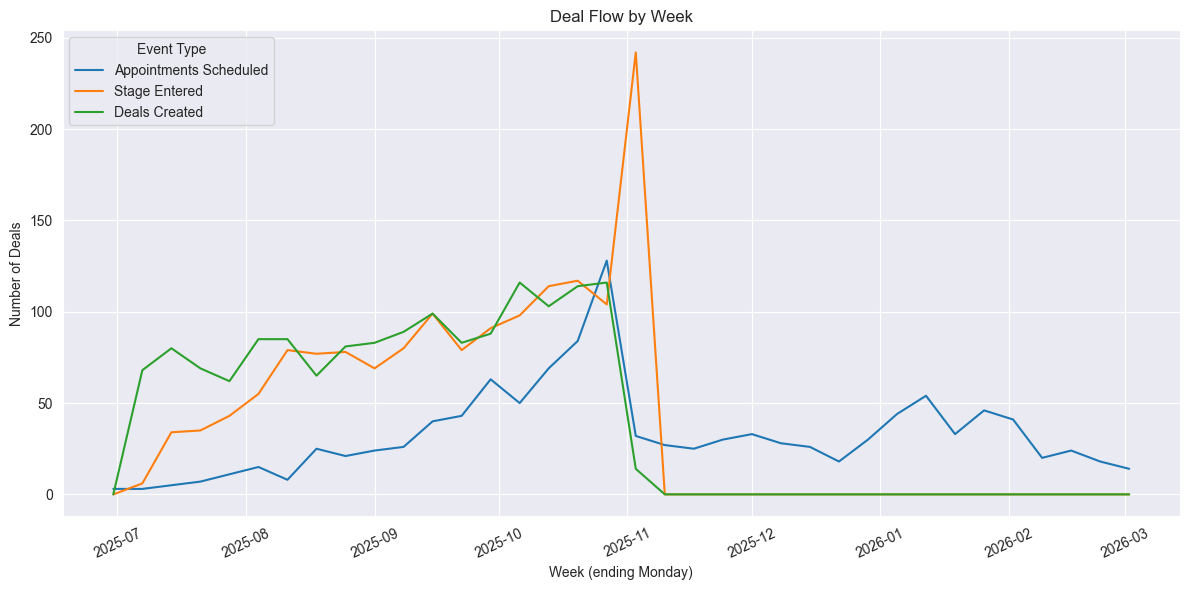

In [15]:

# --- Build weekly counts per event ---
created = (
    df_deals.assign(date=pd.to_datetime(df_deals['deal_created_at']))
    .groupby(pd.Grouper(key='date', freq='W-MON'))
    .size().reset_index(name='count')
    .assign(event='Deals Created')
)

stage_entered = (
    df_deals.assign(date=pd.to_datetime(df_deals['current_deal_stage_entered_at']))
    .groupby(pd.Grouper(key='date', freq='W-MON'))
    .size().reset_index(name='count')
    .assign(event='Stage Entered')
)

appointments = (
    df_deals.assign(date=pd.to_datetime(df_deals['scheduled_appointment_date']))
    .groupby(pd.Grouper(key='date', freq='W-MON'))
    .size().reset_index(name='count')
    .assign(event='Appointments Scheduled')
)

# Combine and ensure all weeks exist per event (fill missing with 0)
weekly = pd.concat([created, stage_entered, appointments], ignore_index=True)

# Make a complete weekly index across the full range, per event
pivot = (
    weekly.pivot_table(index='date', columns='event', values='count', aggfunc='sum', fill_value=0)
    .asfreq('W-MON', fill_value=0)        # ensure continuous weekly frequency
)

# Melt back to tidy format for seaborn
weekly_tidy = (
    pivot.reset_index()
         .melt(id_vars='date', var_name='event', value_name='count')
         .sort_values('date')
)

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_tidy, x='date', y='count', hue='event')
plt.xticks(rotation=25)
plt.xlabel('Week (ending Monday)')
plt.ylabel('Number of Deals')
plt.title('Deal Flow by Week')
plt.legend(title='Event Type', loc='upper left')
plt.tight_layout()
plt.show()


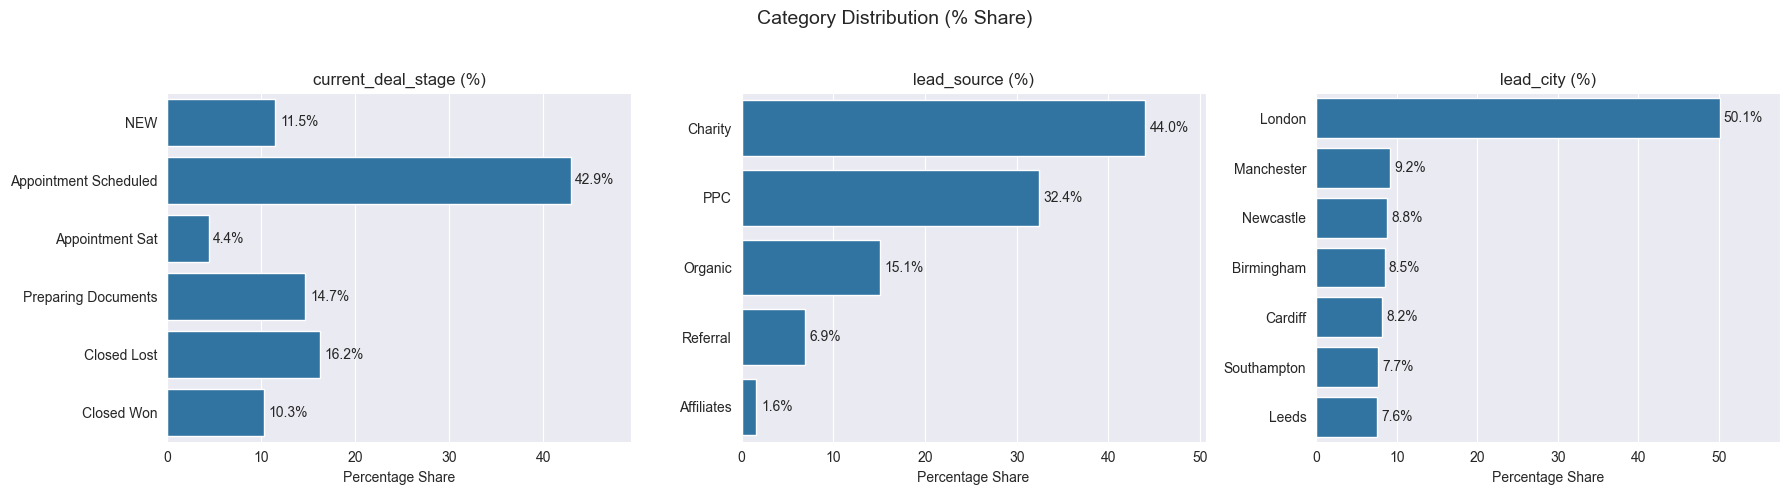

In [16]:
check_cols = df_deals[['current_deal_stage', 'lead_source', 'lead_city']].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.subplots_adjust(wspace=0.4)

for ax, col in zip(axes, check_cols.columns):
    vc = check_cols[col].value_counts(dropna=False)
    pct = (vc / vc.sum() * 100).round(1)
    out = (
        pd.DataFrame({'count': vc, 'pct': pct})
        .rename_axis('value').reset_index()
        .assign(value=lambda d: d['value'].where(d['value'].notna(), '(Missing)'))
    )

    # 🧭 Handle ordering
    if col == 'current_deal_stage' and pd.api.types.is_categorical_dtype(df_deals['current_deal_stage']):
        # Respect the categorical order already defined in df_deals
        categories = df_deals['current_deal_stage'].cat.categories
        out['value'] = pd.Categorical(out['value'], categories=categories, ordered=True)
        out = out.sort_values('value', ascending=True)
    else:
        # For others, sort by count descending
        out = out.sort_values('count', ascending=False)
        out['value'] = pd.Categorical(out['value'], categories=out['value'], ordered=True)

    # Plot horizontal bar chart
    sns.barplot(data=out, x='pct', y='value', ax=ax, orient='h', order=out['value'])
    ax.set_title(f'{col} (%)')
    ax.set_xlabel('Percentage Share')
    ax.set_ylabel('')

    # Add labels
    for patch, pct_val in zip(ax.patches, out['pct'].tolist()):
        x = patch.get_width()
        y = patch.get_y() + patch.get_height() / 2
        ax.text(x + 0.5, y, f'{pct_val}%', va='center')

    # Add padding on the right for text labels
    right = max(out['pct']) if len(out) else 0
    ax.set_xlim(0, right * 1.15 if right > 0 else 1)

plt.suptitle('Category Distribution (% Share)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## ℹ : Categorical Data Insights

### Current Deal Stage % Share
Looking at the status of all deals in our dataset we can see that:
- **42.9% are currently scheduled for an appointment. This seems disproportionate**, it could be a sign of many appointments scheduled long into the future in we're experiencing a bottle neck attending them.
- **Of all closed deals 61% are being lost**: This is just be looked into as a priority. Are Octopus Legacy's prices competitive? Poor customer experience?

### Lead Source Generation
- 44% of all leads come from 'Charity' which suggests Octopus Legacy potentially has some really valuable partnerships (We'd need to evaluate uf there are any costs associated with these Charities).
- PPC makes up 32% of leads, we'd need to assess the acquisition costs to assess whether this is a good lead generation stream. Although 32% does seem a little high which indicates Octopus Legacy isn't yet a very recognisable service.

### Lead City
- Half of all leads come from London which is typical of a tech start up but disproportionate to the market opportunity. Octopus Legacy offers a product which is needed by all demographics so should consider expansion outside of London.


<div style="display: flex; align-items: flex-start;">
  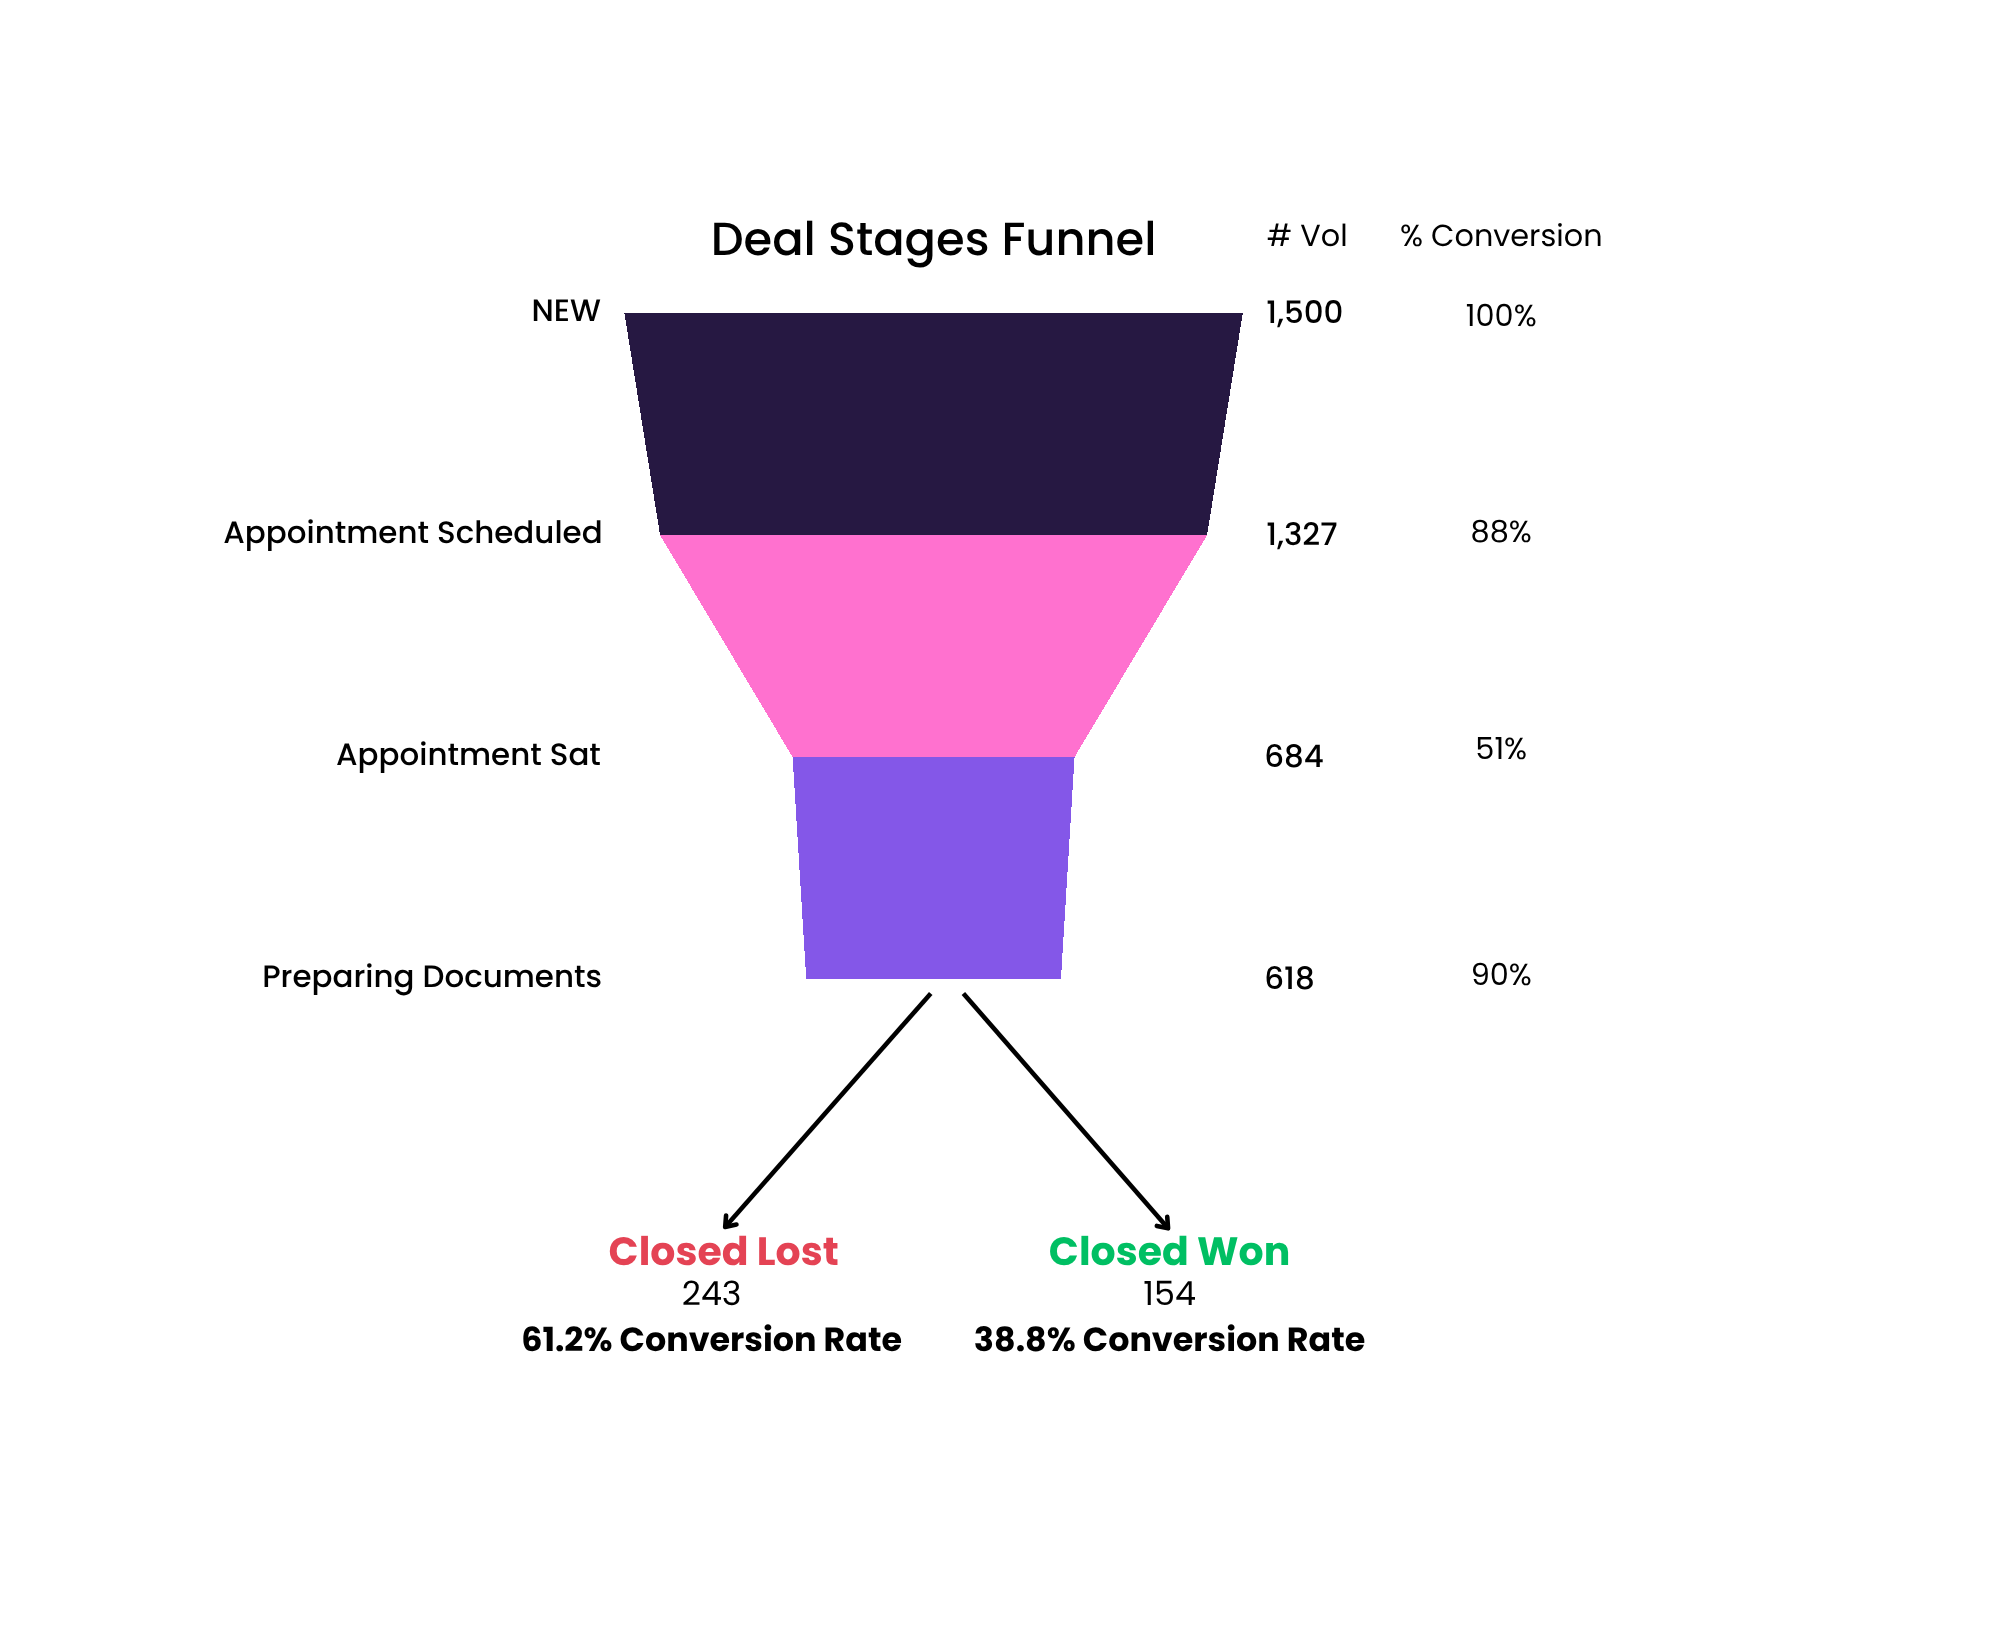
  <p>
    <b>Lead Funnel:</b><br>
    We know that leads have to go through a process from <i>New</i> → setting appointments → eventually leading to an outcome.<br>
    Conversion drops sharply from <i>Preparing Documents</i> → <i>Closing</i>.<br><br>
    <b>Google Docs Link:</b>
    <a href="https://docs.google.com/spreadsheets/d/11PPZhg9DnRUcE6piqqyU9Am97hEsHyO0olbUxEiVB0g/edit?usp=sharing" target="_blank">
      View Spreadsheet
    </a>
  </p>
</div>


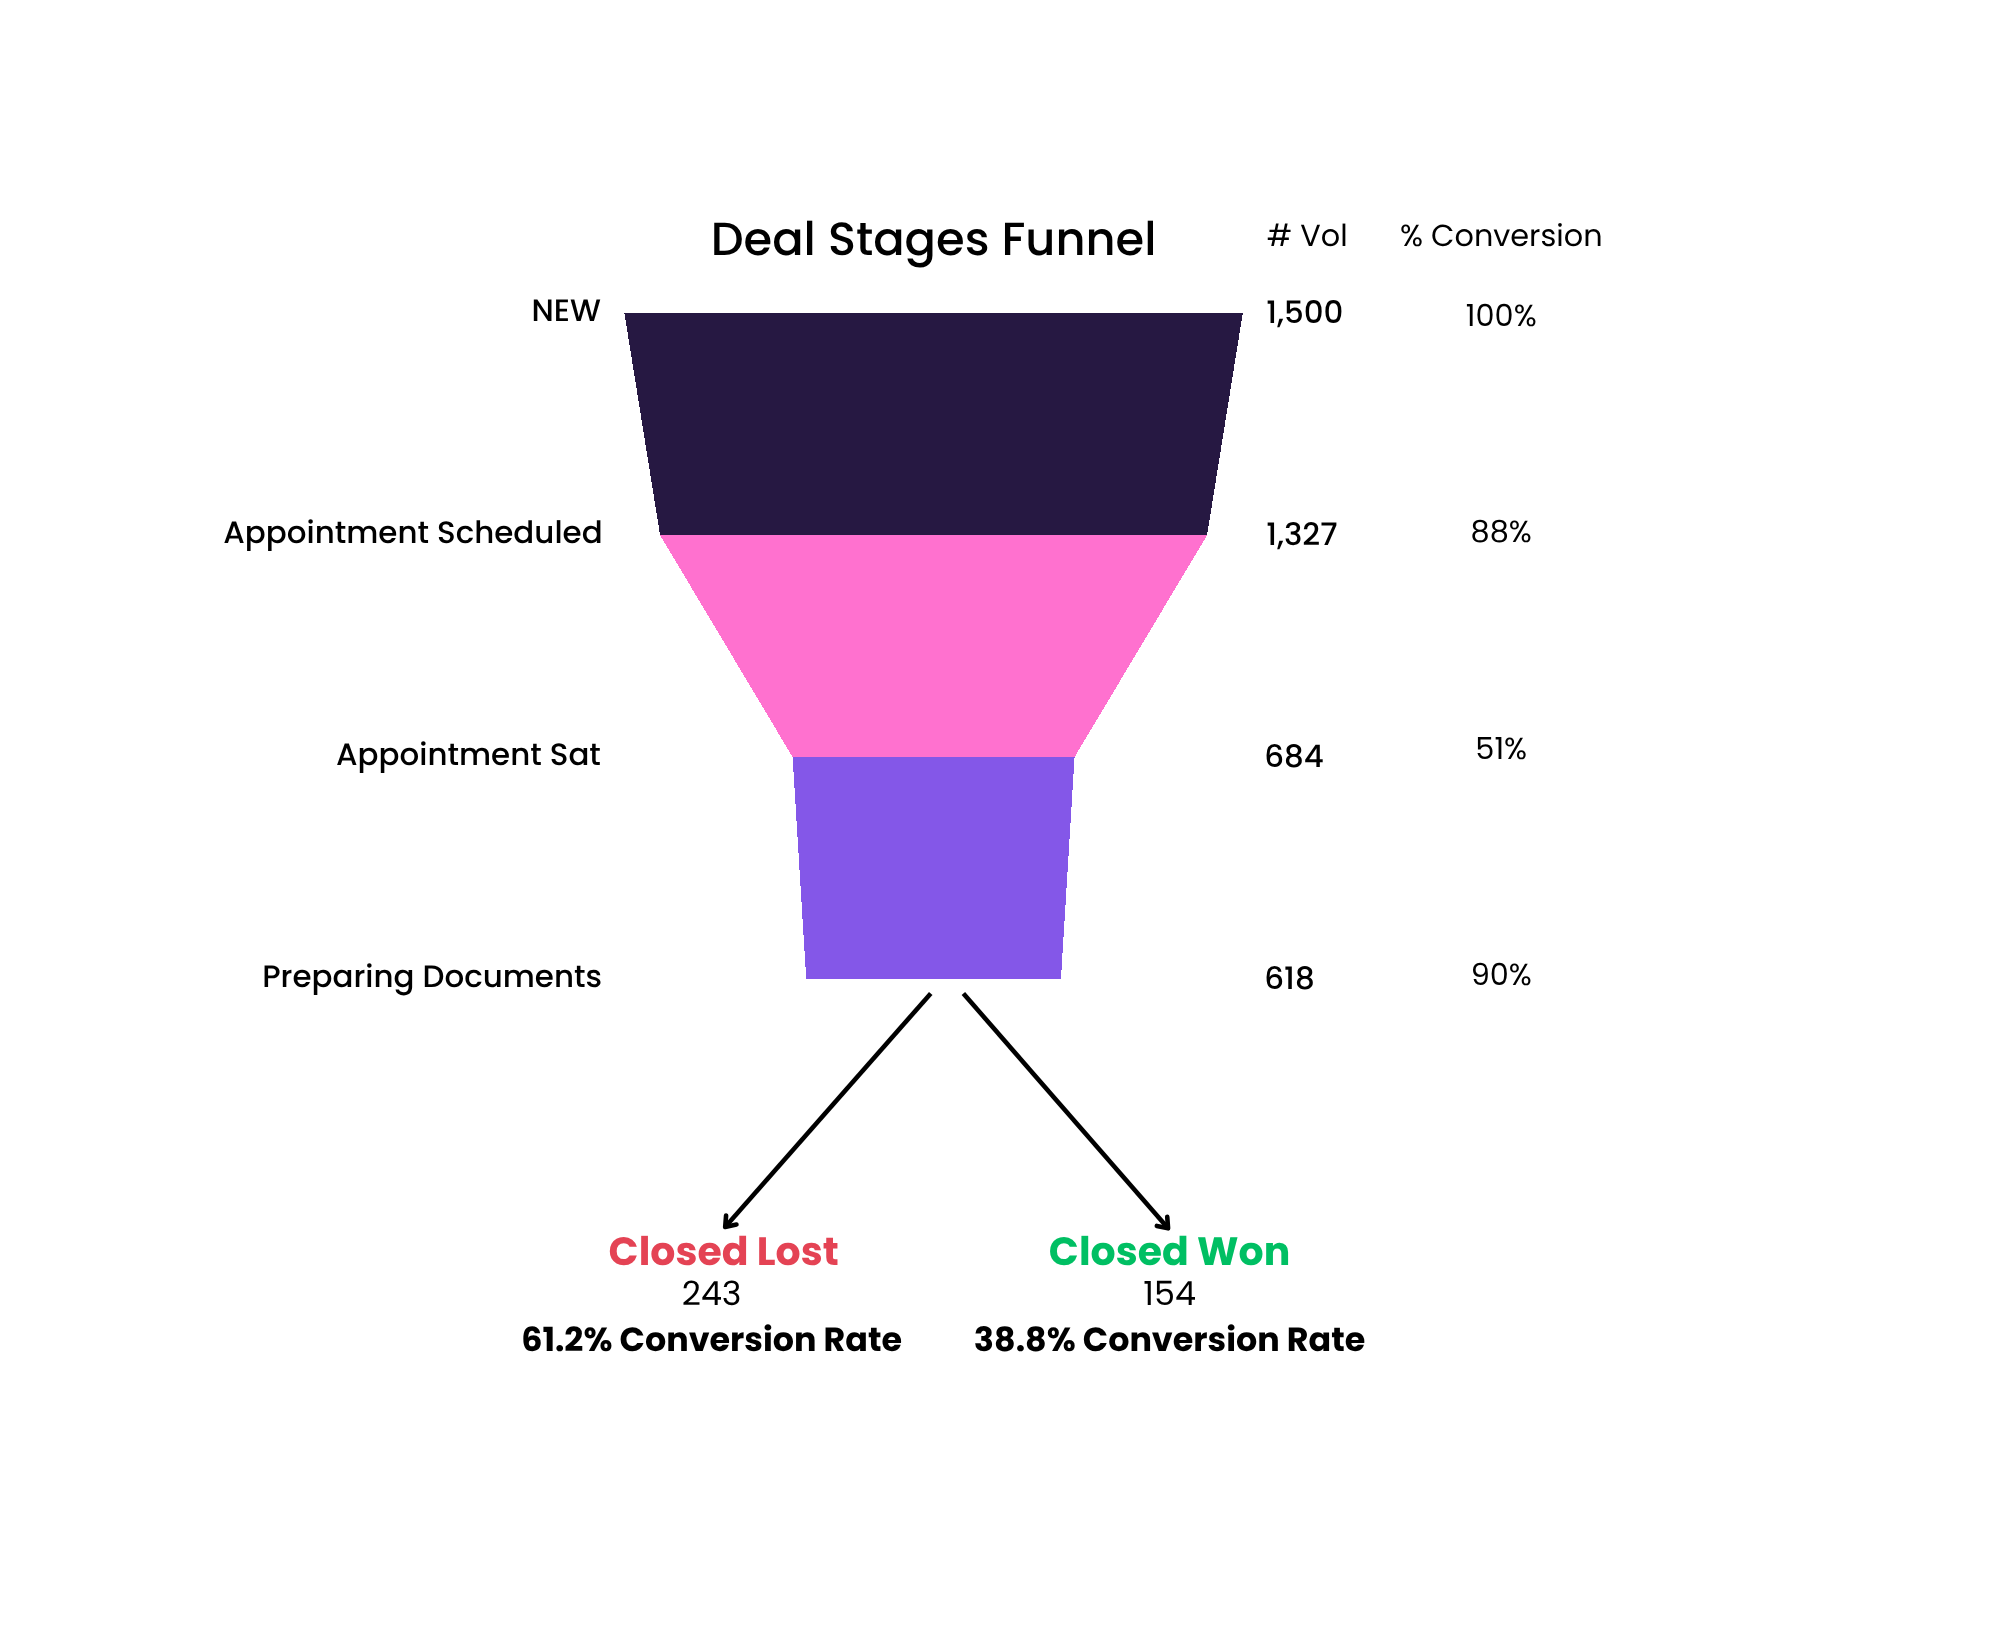

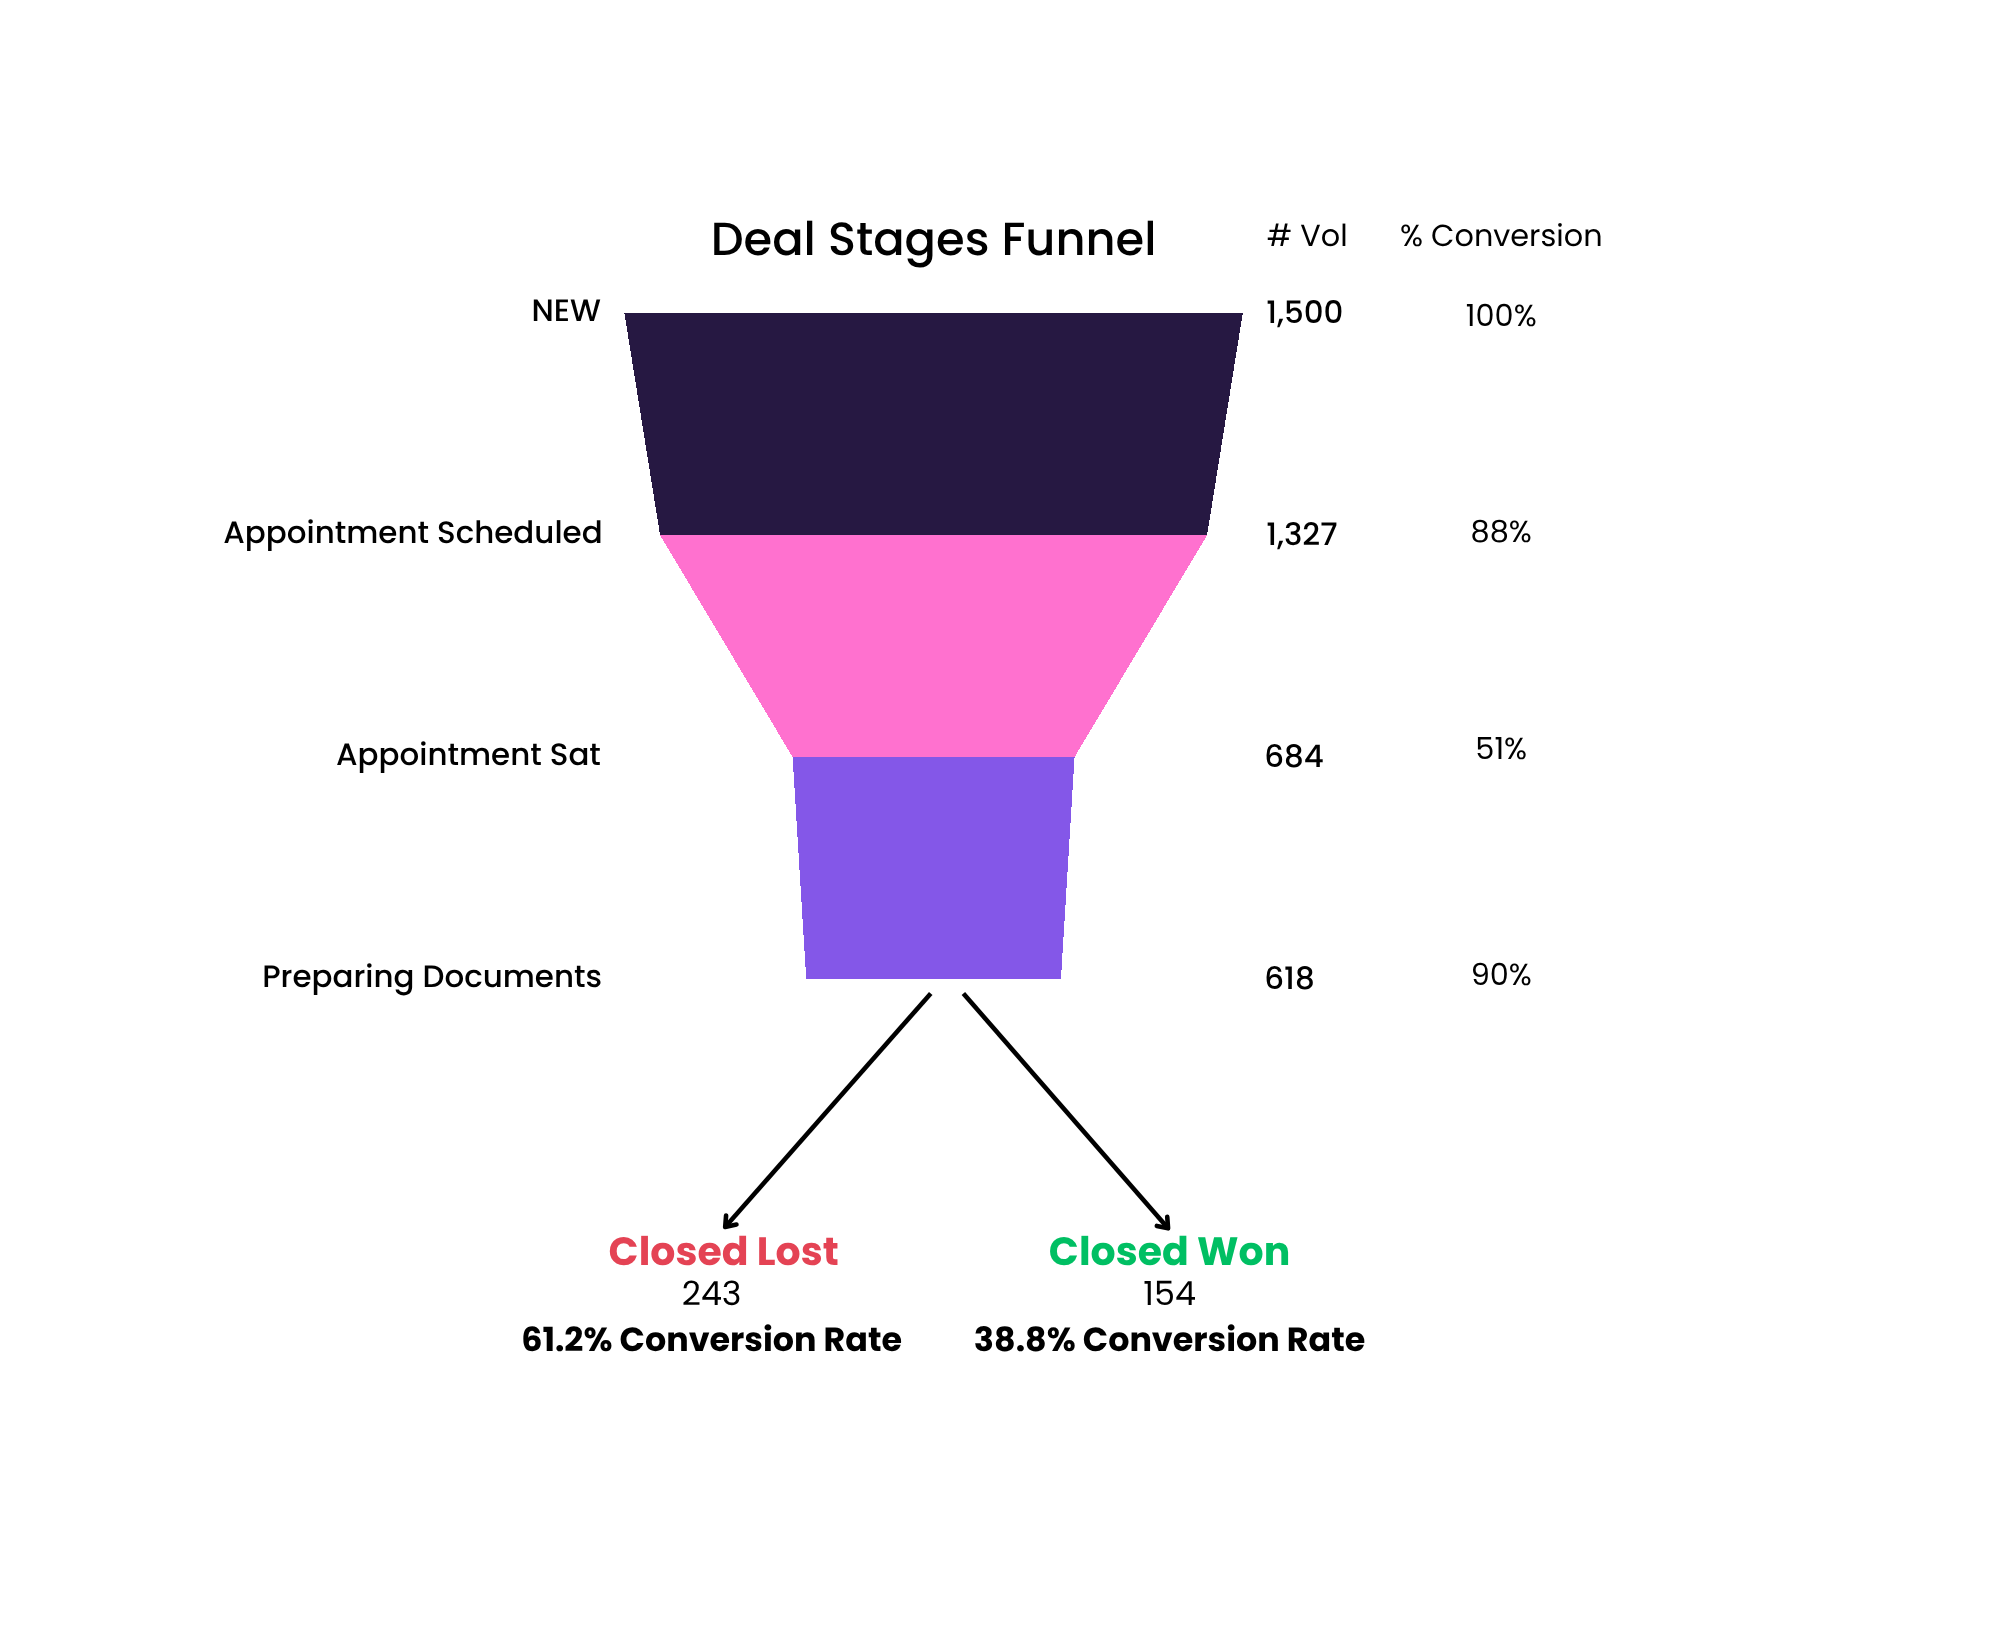

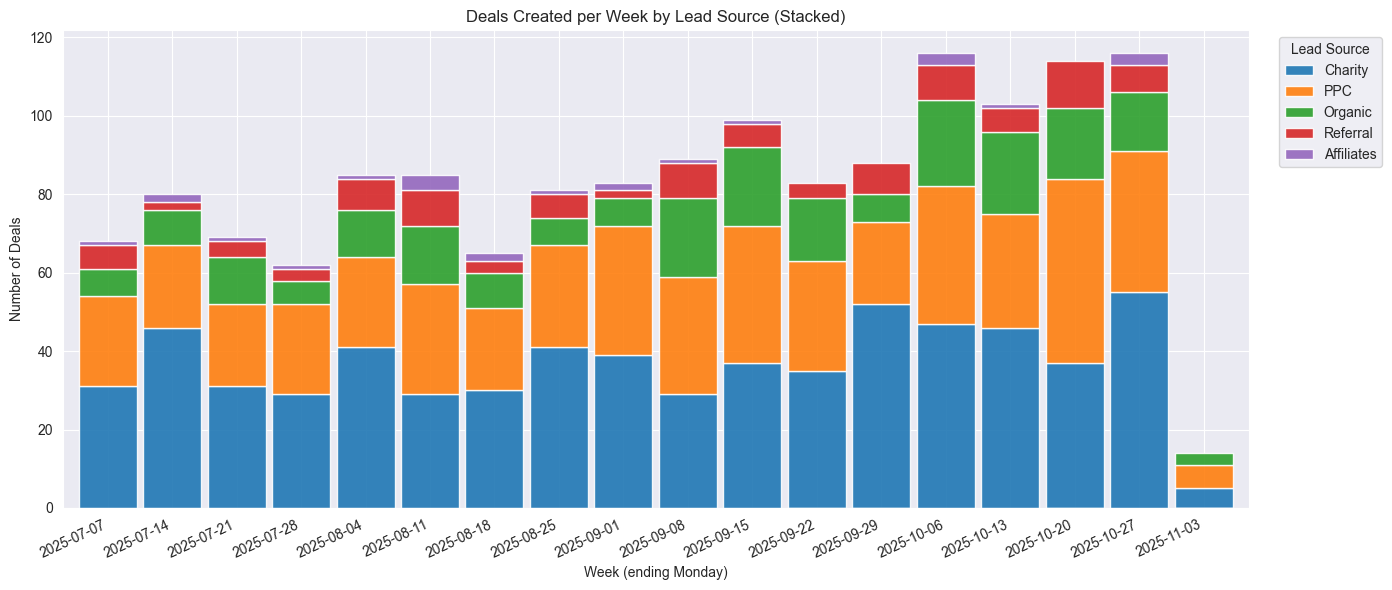

In [17]:
# Ensure datetime and handle missing lead_source explicitly
tmp = df_deals.copy()
tmp['deal_created_at'] = pd.to_datetime(tmp['deal_created_at'])


tmp['lead_source'] = tmp['lead_source'].fillna('(Missing)')

# Weekly counts (weeks ending Monday — change to 'W-SUN' if you prefer)
weekly = (
    tmp.groupby([pd.Grouper(key='deal_created_at', freq='W-MON'), 'lead_source'])
       .size()
       .unstack(fill_value=0)
       .sort_index()
)

# Ensure continuous weekly index
weekly = weekly.asfreq('W-MON', fill_value=0)

# (Optional) order legend/columns by total volume
weekly = weekly.loc[:, weekly.sum().sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(14, 6))
weekly.plot(kind='bar', stacked=True, width=0.9, alpha=0.9, ax=ax)

ax.set_title('Deals Created per Week by Lead Source (Stacked)')
ax.set_xlabel('Week (ending Monday)')
ax.set_ylabel('Number of Deals')
ax.legend(title='Lead Source', bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Format x-axis labels as YYYY-MM-DD ---
# Make sure ticks align with bars, then set string labels from the DatetimeIndex
ax.set_xticks(range(len(weekly.index)))
ax.set_xticklabels(weekly.index.strftime('%Y-%m-%d'), rotation=25, ha='right')

plt.tight_layout()
plt.show()


In [18]:

weekly.to_excel("weekly.xlsx",sheet_name='weekly')

**Google Docs Link:**
https://docs.google.com/spreadsheets/d/11PPZhg9DnRUcE6piqqyU9Am97hEsHyO0olbUxEiVB0g/edit?usp=sharing


### Deals Are Growing Consistently
Deals created by week have been increasing steadily largely driven by Charity and PPC sources as we saw in the previous charts. Let's dig deeper to see if there are any Month on Month changes.

The below screenshot is from Google Sheets (Link above). It shows that we had some great growth from Organic leads (The best form of acquisition), we should dig deeper to see if there was internal/external factors which drove organic leads in September-2025.




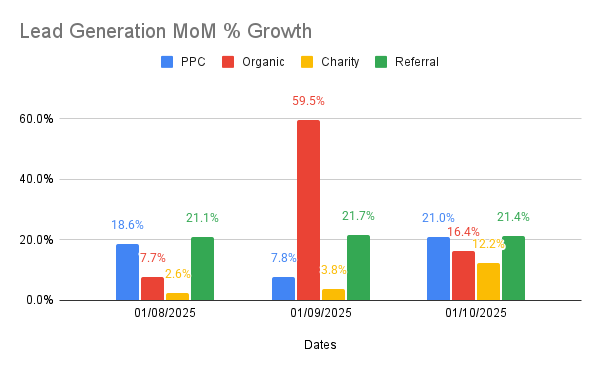

deal_order  current_deal_stage   
1           NEW                      173
2           Appointment Scheduled    643
3           Appointment Sat           66
4           Preparing Documents      221
5           Closed Lost              243
6           Closed Won               154
Name: count, dtype: int64


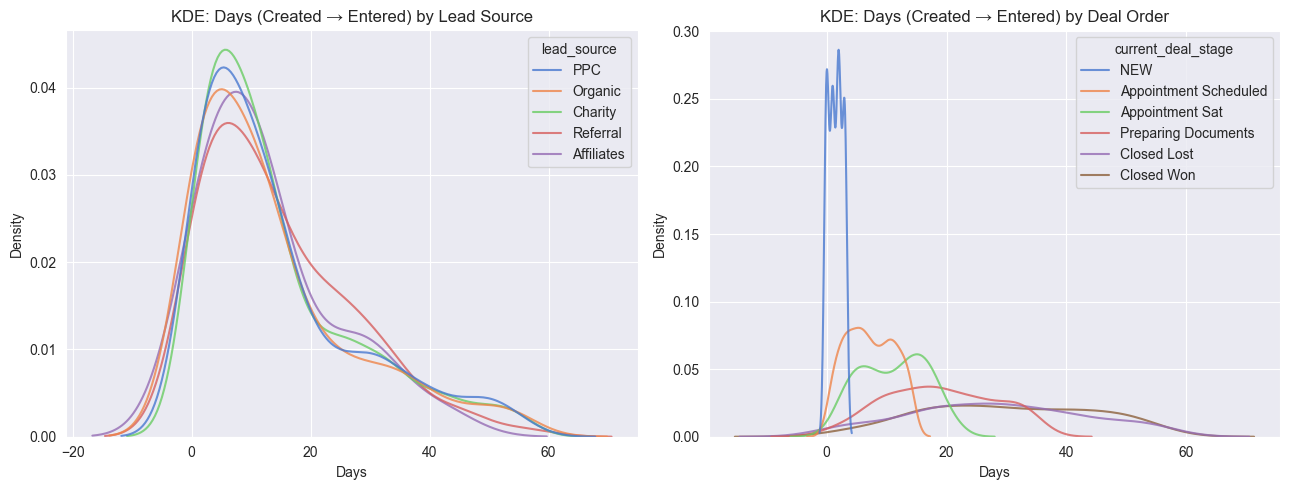

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

sns.kdeplot(
    data=df_deals,
    x='days_diff_created_to_entered',
    hue='lead_source',
    fill=False,
    common_norm=False,
    alpha=0.8,
    ax=ax[0],
    palette='muted'
)
ax[0].set_title('KDE: Days (Created → Entered) by Lead Source')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Density')

sns.kdeplot(
    data=df_deals,
    x='days_diff_created_to_entered',
    hue='current_deal_stage',
    fill=False,
    common_norm=False,
    alpha=0.8,
    ax=ax[1],
    palette='muted'
)
ax[1].set_title('KDE: Days (Created → Entered) by Deal Order')
ax[1].set_xlabel('Days')
ax[1].set_ylabel('Density')

plt.tight_layout()

print(df_deals[['deal_order','current_deal_stage']].value_counts().sort_index())

plt.show()


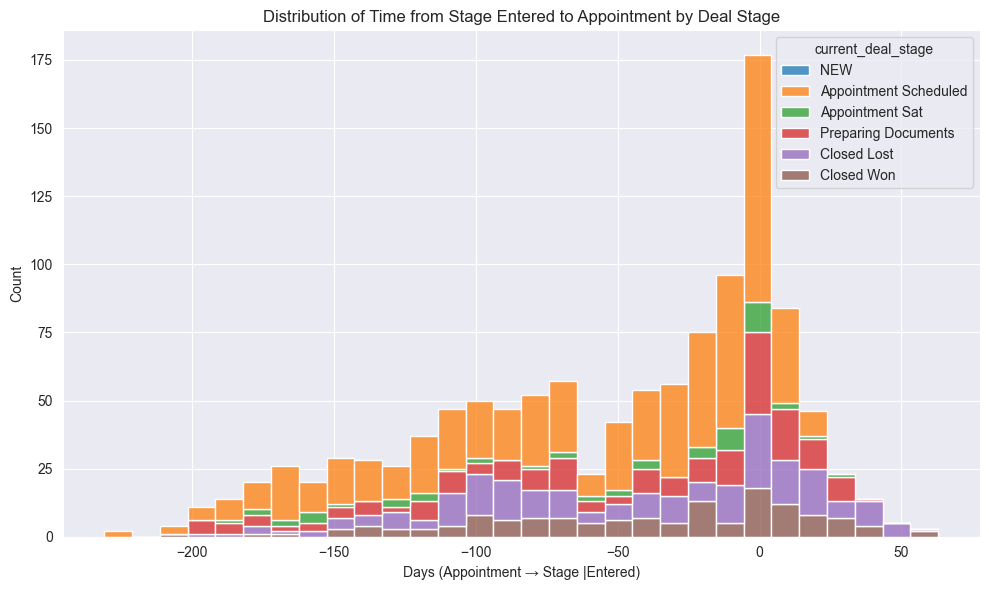

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_deals,
    x='days_diff_entered_to_appointment',
    hue='current_deal_stage',
    multiple='stack',
    bins=30,
    edgecolor=None
)

plt.xlabel('Days (Appointment → Stage |Entered)')
plt.ylabel('Count')
plt.title('Distribution of Time from Stage Entered to Appointment by Deal Stage')
plt.tight_layout()
plt.show()


### ℹ : Appointments

It looks like we have some interesting consultant driven data quality issues, I would say this is more a process issue than data driven.

Appointments are the 2nd stage of the conversion funnel yet we're seeing latter stages being completed prior to an appointment being sat, this could be:
- Consultants catching up on admin later i.e admin backlog
- Some deals are being worked on/finished prior to needing a scheduled appointment
- There are multiple appointments for 1 deal

We'll need to take a sample of appointments and find out from Consultants the circumstances that lead to it.

# Deal Line Items

In [21]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

SELECT
    * EXCLUDE (created_at),

    DATE(created_at) AS created_at,

    CASE
        WHEN unit_discount_inc_vat = 0 THEN unit_price_inc_vat * quantity
        WHEN unit_discount_inc_vat <> 0 THEN unit_discount_inc_vat * quantity
        ELSE NULL
    END AS item_revenue,

 FROM df_line_items_raw


"""

df_line_items = con.execute(query).fetchdf()
df_line_items.head(10)


,line_item_id,invoice_id,deal_id,product_name,quantity,unit_price_inc_vat,unit_discount_inc_vat,vat_rate,currency,product_category,invoice_status,created_at,item_revenue
0,3982498,10477839,523892,Couples Phone Will,1,250,0,0.2,GBP,Will,Paid,2025-10-28,250
1,3982499,10477899,523895,Simple In Person Will,1,150,0,0.2,GBP,Will,Draft,2025-10-28,150
2,3982500,10478019,523901,Will + Trust,1,450,0,0.2,GBP,Will,Paid,2025-08-20,450
3,3982501,10478019,523901,Simple LPA,1,150,0,0.2,GBP,LPA,Paid,2025-08-20,150
4,3982502,10478039,523902,Lasting Power of Attorney (Full),1,499,0,0.2,GBP,LPA,Paid,2025-08-12,499
5,3982503,10478039,523902,Couples Phone Will,1,250,150,0.2,GBP,Will,Paid,2025-08-12,150
6,3982504,10478079,523904,Classic Package,1,1199,0,0.2,GBP,Package,Paid,2025-10-28,1199
7,3982505,10478079,523904,Couples Will,1,250,0,0.2,GBP,Will,Paid,2025-10-28,250
8,3982506,10478119,523906,Severance of Tenancy,1,150,0,0.2,GBP,Other,Paid,2025-07-11,150
9,3982507,10478119,523906,Premier Package,2,2699,0,0.2,GBP,Package,Paid,2025-07-11,5398


In [22]:
df_line_items.isna().sum()


line_item_id             0
invoice_id               0
deal_id                  0
product_name             0
quantity                 0
unit_price_inc_vat       0
unit_discount_inc_vat    0
vat_rate                 0
currency                 0
product_category         0
invoice_status           0
created_at               0
item_revenue             0
dtype: int64

In [23]:
check_cols = df_line_items[['product_name', 'currency', 'product_category','invoice_status']]

for col in check_cols.columns:
    print(df_line_items[col].value_counts())

product_name
Couples Phone Will                    87
Simple In Person Will                 80
Simple Phone Will                     79
Couple In Person Will                 69
Will With a Trust                     59
Classic Package                       35
Severance of Tenancy                  31
Simple LPA                            30
Premier Package                       26
FULL LPA                              25
Couples Phone-Based Will              21
Trust-Backed Will                     20
Couples Will                          20
Will with Trust                       19
Couples Will (In Person)              19
Will + Trust                          16
Couples Phone Will Service            14
Couples Will (Phone)                  14
Phone Will                            13
Simple Will                           12
Basic Will (Phone)                    12
Couples In-Person Will                11
Simple Will (Phone)                   11
In-Person Simple Will                  9
Las

In [24]:
df_line_items.describe().T

,count,mean,min,25%,50%,75%,max,std
line_item_id,827.0,3982911.0,3982498.0,3982704.5,3982911.0,3983117.5,3983324.0,238.87863
invoice_id,827.0,10492987.125756,10477839.0,10485939.0,10492879.0,10500109.0,10507819.0,8388.360075
deal_id,827.0,524649.406288,523892.0,524297.0,524644.0,525005.5,525391.0,419.418004
quantity,827.0,1.061669,1.0,1.0,1.0,1.0,2.0,0.240698
unit_price_inc_vat,827.0,434.232164,150.0,150.0,250.0,450.0,2699.0,573.736666
unit_discount_inc_vat,827.0,49.334946,0.0,0.0,0.0,150.0,150.0,70.514661
vat_rate,827.0,0.2,0.2,0.2,0.2,0.2,0.2,0.0
created_at,827,2025-09-17 04:03:46.360338,2025-07-04 00:00:00,2025-08-20 00:00:00,2025-09-20 00:00:00,2025-10-20 00:00:00,2025-10-28 00:00:00,NaN
item_revenue,827.0,425.638452,150.0,150.0,150.0,450.0,5398.0,662.686448


In [25]:
df_line_items.dtypes

line_item_id                      int64
invoice_id                        int64
deal_id                           int64
product_name                     object
quantity                          int64
unit_price_inc_vat                int64
unit_discount_inc_vat             int64
vat_rate                        float64
currency                         object
product_category                 object
invoice_status                   object
created_at               datetime64[us]
item_revenue                      int64
dtype: object

In [26]:
df_line_items['product_name'].value_counts()

product_name
Couples Phone Will                    87
Simple In Person Will                 80
Simple Phone Will                     79
Couple In Person Will                 69
Will With a Trust                     59
Classic Package                       35
Severance of Tenancy                  31
Simple LPA                            30
Premier Package                       26
FULL LPA                              25
Couples Phone-Based Will              21
Trust-Backed Will                     20
Couples Will                          20
Will with Trust                       19
Couples Will (In Person)              19
Will + Trust                          16
Couples Phone Will Service            14
Couples Will (Phone)                  14
Phone Will                            13
Simple Will                           12
Basic Will (Phone)                    12
Couples In-Person Will                11
Simple Will (Phone)                   11
In-Person Simple Will                  9
Las

In [27]:
#df_line_items.to_excel("df_line_items.xlsx",sheet_name='df_line_items')

### ℹ : Product Offering

We have a have over 40 unique product names which suggests this data could be input by consultants instead of a pe-determined drop list or automated product type. We won't aggregate the product names for this analysis as we can work from the product category to drive insights.

Octopus Legacy offers 4 main categories of product:
- Wills -> The 'gets them in the door' product: Represents 71% of sales volume and 36% of revenue (Avg Order Revenue: £217)
- Package -> The most valuable product: Represents 11% of sales volume and 53% of revenue (Avg Order Revenue: £1,957)



In [28]:

print(df_line_items.groupby(["product_category"]).agg(avg_sales=("item_revenue", "mean"),count=("product_category", "size"), total_revenue=("item_revenue", "sum")).reset_index().sort_values(by=['total_revenue'], ascending=False))

print("\n")

print(df_line_items.groupby(["invoice_status"]).agg(avg_sales=("item_revenue", "mean"),count=("product_category", "size"), total_revenue=("item_revenue", "sum")).reset_index().sort_values(by=['total_revenue'], ascending=False))



  product_category    avg_sales  count  total_revenue
2          Package  1956.842105     95         185900
3             Will   216.751269    591         128100
0              LPA   333.184783     92          30653
1            Other   150.000000     49           7350


  invoice_status   avg_sales  count  total_revenue
2           Paid  443.699029    515         228505
1          Draft  392.804688    256         100558
0      Cancelled  486.870968     31          15093
3       Refunded  313.880000     25           7847


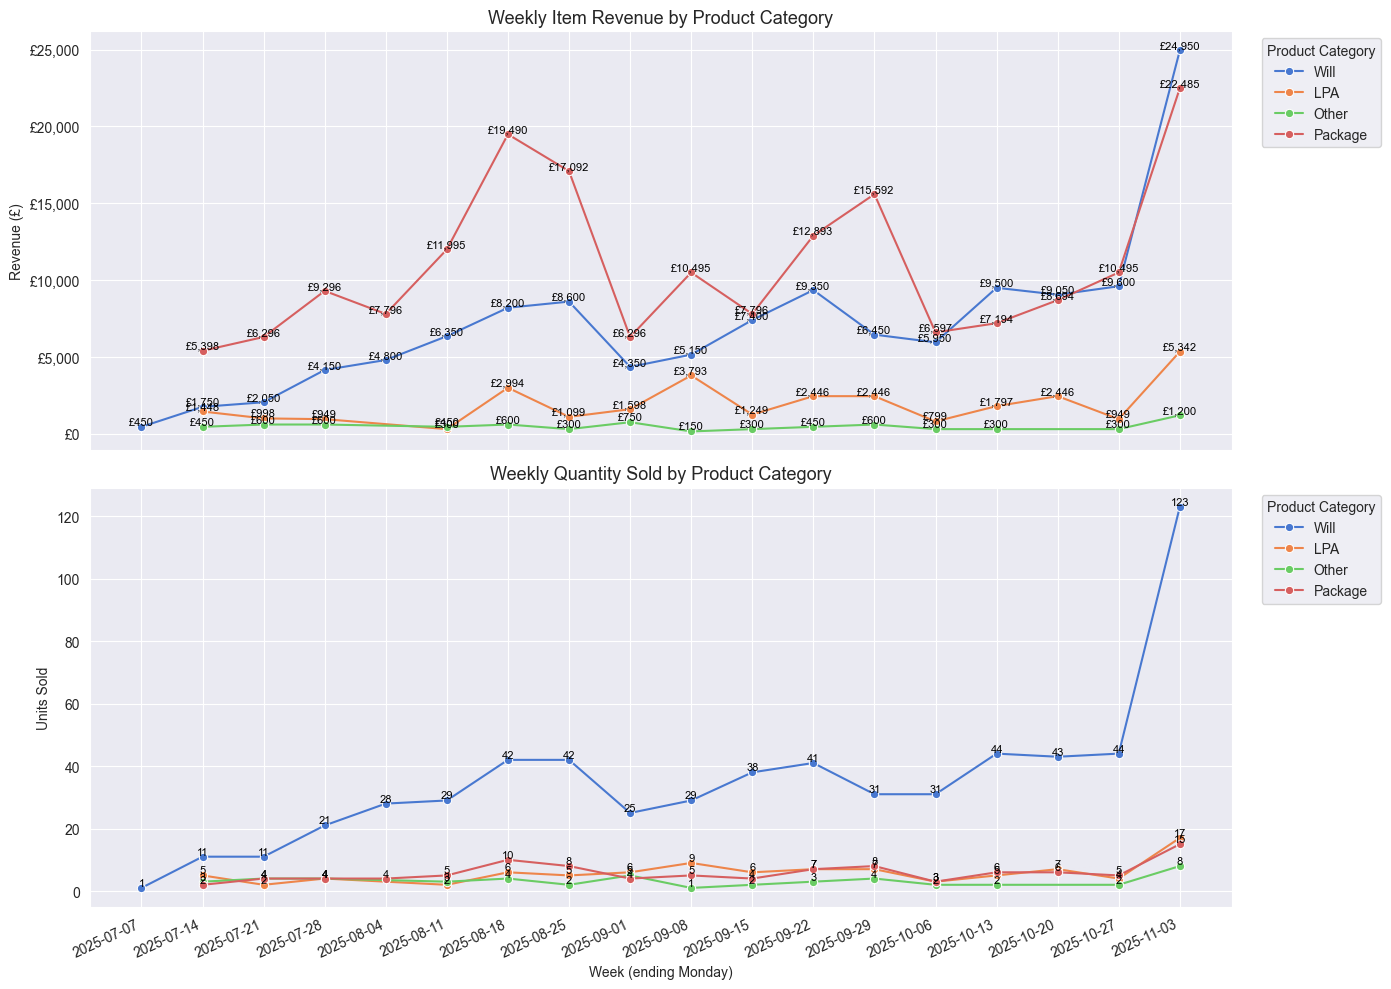

In [29]:
# --- Prep data ---
df_line_items['created_at'] = pd.to_datetime(df_line_items['created_at'])

# Weekly revenue
weekly_rev = (
    df_line_items
    .groupby([pd.Grouper(key='created_at', freq='W-MON'), 'product_category'])
    ['item_revenue']
    .sum()
    .reset_index()
)

# Weekly quantity
weekly_qty = (
    df_line_items
    .groupby([pd.Grouper(key='created_at', freq='W-MON'), 'product_category'])
    ['quantity']
    .sum()
    .reset_index()
)

# Sorted weekly order
x_order = sorted(weekly_rev['created_at'].unique())

# --- Plot setup ---
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
plt.subplots_adjust(hspace=0.35)

# Formatter for GBP (£)
gbp_formatter = FuncFormatter(lambda x, _: f"£{x:,.0f}")

# --- Chart 1: Weekly revenue ---
sns.lineplot(
    data=weekly_rev,
    x='created_at',
    y='item_revenue',
    hue='product_category',
    marker='o',
    palette='muted',
    ax=axes[0]
)

axes[0].yaxis.set_major_formatter(gbp_formatter)
axes[0].set_title('Weekly Item Revenue by Product Category', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_ylabel('Revenue (£)')
axes[0].legend(title='Product Category', bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Add data labels for revenue chart ---
for line_data in weekly_rev.groupby('product_category'):
    category, data = line_data
    for x, y in zip(data['created_at'], data['item_revenue']):
        axes[0].text(
            x, y, f"£{y:,.0f}",
            fontsize=8, color='black', ha='center', va='bottom'
        )

# --- Chart 2: Weekly quantity ---
sns.lineplot(
    data=weekly_qty,
    x='created_at',
    y='quantity',
    hue='product_category',
    marker='o',
    palette='muted',
    ax=axes[1]
)

axes[1].set_title('Weekly Quantity Sold by Product Category', fontsize=13)
axes[1].set_xlabel('Week (ending Monday)')
axes[1].set_ylabel('Units Sold')
axes[1].legend(title='Product Category', bbox_to_anchor=(1.02, 1), loc='upper left')

# --- Add data labels for quantity chart ---
for line_data in weekly_qty.groupby('product_category'):
    category, data = line_data
    for x, y in zip(data['created_at'], data['quantity']):
        axes[1].text(
            x, y, f"{y:,.0f}",
            fontsize=8, color='black', ha='center', va='bottom'
        )

# --- Format x-axis labels ---
axes[1].set_xticks(x_order)
axes[1].set_xticklabels(pd.to_datetime(x_order).strftime('%Y-%m-%d'), rotation=25, ha='right')

plt.tight_layout()
plt.show()


### ℹ : Weekly Revenue Trends

We also see the early November spike in activity we saw in our initial deals dataset. It looks like there is some genuine increase in activity but we'll have to remain a little skeptical of the results until we've cleared up the deals data quality issues. For now we'll give the benefit of the doubt that these orders are correct.

- End of October / Early November saw a significant increase in sales specifically for Wills and Packages.
- The Wills increase in sales could lead to new upselling opportunities.

Let's dive deeper into our line items when looking at total basket purchase. Are there any upselling or products bought in combination?


In [30]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

WITH base AS (

    SELECT
        *,
        CASE
            WHEN unit_discount_inc_vat = 0 THEN unit_price_inc_vat * quantity
            WHEN unit_discount_inc_vat <> 0 THEN unit_discount_inc_vat * quantity
            ELSE 0
        END AS item_revenue,

    FROM df_line_items_raw

)

SELECT
    deal_id,
    invoice_status,
    DATE(created_at) AS created_at,
    GROUP_CONCAT(product_category) AS gpd_product_category,
    SUM(item_revenue) AS item_revenue,

 FROM base

 GROUP BY ALL



"""

df_line_grouped_items = con.execute(query).fetchdf()
df_line_grouped_items.head(20)


,deal_id,invoice_status,created_at,gpd_product_category,item_revenue
0,523919,Draft,2025-09-14,Will,150.0
1,523992,Paid,2025-09-14,Will,150.0
2,524021,Draft,2025-07-08,"LPA,LPA",649.0
3,524025,Draft,2025-10-24,Will,250.0
4,524079,Paid,2025-09-15,Will,150.0
5,524163,Paid,2025-09-26,Will,450.0
6,524193,Draft,2025-07-24,Will,150.0
7,524228,Paid,2025-10-10,"LPA,Will",649.0
8,524260,Draft,2025-07-29,Will,500.0
9,524304,Draft,2025-07-16,"LPA,Package",2897.0


### 🚨 Potential duplication for Products

We're seeing a deal where there are multiple wills being sold. What makes this especially suspicious is if we dive deeper into deal_id 524223 we see a purchase for 2 individual wills & a couple will. This could potentially be incorrect input.

Given the customer has paid we'll assume there isn't a mistake. let's check refunded deals just to make sure we're not seeing a pattern.


In [31]:
df_line_items.loc[df_line_items['deal_id'] == 523957]

,line_item_id,invoice_id,deal_id,product_name,quantity,unit_price_inc_vat,unit_discount_inc_vat,vat_rate,currency,product_category,invoice_status,created_at,item_revenue
27,3982525,10479139,523957,Couples Phone Will,1,250,0,0.2,GBP,Will,Paid,2025-09-21,250
28,3982526,10479139,523957,Simple In Person Will,2,150,0,0.2,GBP,Will,Paid,2025-09-21,300


We're not seeing any refunds with potential duplicate Wills. We'll follow up separately to make sure this isn't the case.

In [32]:
df_line_items.loc[df_line_items['invoice_status'] == 'Refunded']

,line_item_id,invoice_id,deal_id,product_name,quantity,unit_price_inc_vat,unit_discount_inc_vat,vat_rate,currency,product_category,invoice_status,created_at,item_revenue
21,3982519,10478779,523939,Simple In Person Will,1,150,0,0.2,GBP,Will,Refunded,2025-07-31,150
39,3982537,10479519,523976,Simple Phone Will,1,150,150,0.2,GBP,Will,Refunded,2025-09-17,150
194,3982692,10485699,524285,Severance of Tenancy,1,150,0,0.2,GBP,Other,Refunded,2025-09-25,150
195,3982693,10485699,524285,Couple In Person Will,1,250,0,0.2,GBP,Will,Refunded,2025-09-25,250
227,3982725,10486359,524318,Simple Phone Will,1,150,0,0.2,GBP,Will,Refunded,2025-10-28,150
249,3982747,10487059,524353,Trust-Backed Will,1,450,150,0.2,GBP,Will,Refunded,2025-08-24,150
250,3982748,10487059,524353,Simple Phone Will,1,150,150,0.2,GBP,Will,Refunded,2025-08-24,150
371,3982869,10491179,524559,Simple Phone Will,1,150,150,0.2,GBP,Will,Refunded,2025-08-22,150
413,3982911,10492879,524644,FULL LPA,1,499,0,0.2,GBP,LPA,Refunded,2025-10-28,499
414,3982912,10492879,524644,Trust-Backed Will,1,450,150,0.2,GBP,Will,Refunded,2025-10-28,150


Without a timestamp it's impossible to say whether there a particular product leads to a higher probability of another product being purchased.

There's a few ways we could follow this up:
- Include events data which has timestamps for each product
- Survey / Call with consultants to gauge the customer multiple purchase intent
- Apply bayesian probabilities to see the probability of customers making multiple purchases.

In [33]:
df_line_grouped_items.groupby(["gpd_product_category"]).agg(avg_sales=("item_revenue", "mean"),count=("gpd_product_category", "size"), total_revenue=("item_revenue", "sum")).reset_index().sort_values(by=['count'], ascending=False)


,gpd_product_category,avg_sales,count,total_revenue
16,Will,220.221607,361,79500.0
23,"Will,Will",400.000000,44,17600.0
5,"LPA,Will",595.576923,26,15485.0
13,"Package,Will",2022.869565,23,46526.0
21,"Will,Package",2333.695652,23,53675.0
17,"Will,LPA",542.727273,22,11940.0
20,"Will,Other",381.250000,16,6100.0
9,"Other,Will",392.307692,13,5100.0
3,"LPA,Package",2130.363636,11,23434.0
10,"Package,LPA",2461.000000,8,19688.0


# Combining Deals & Line Items

In [34]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

SELECT
    deal.deal_id,
    deal.contact_id,
    deal.current_deal_stage,
    deal.lead_source,
    deal.deal_created_at,
    deal.current_deal_stage_entered_at,
    deal.scheduled_appointment_date,
    deal.deal_order,
    deal.lead_city,
    deal.days_diff_created_to_entered,
    deal.days_diff_entered_to_appointment,

    item.invoice_status,
    item.created_at AS items_created_at,
    item.gpd_product_category AS deal_product_categories,
    item.item_revenue AS deal_revenue,

FROM df_deals AS deal

LEFT JOIN df_line_grouped_items AS item
    ON deal.deal_id = item.deal_id

"""

df_combined = con.execute(query).fetchdf()
df_combined.head(10)


,deal_id,contact_id,current_deal_stage,lead_source,deal_created_at,current_deal_stage_entered_at,scheduled_appointment_date,deal_order,lead_city,days_diff_created_to_entered,days_diff_entered_to_appointment,invoice_status,items_created_at,deal_product_categories,deal_revenue
0,523892,200394,Closed Won,PPC,2025-10-13,2025-10-28,2025-10-23,6,London,15,5,Paid,2025-10-28,Will,250.0
1,523895,200233,Appointment Sat,Organic,2025-10-20,2025-10-27,2025-10-22,3,London,7,5,Draft,2025-10-28,Will,150.0
2,523901,201080,Closed Won,PPC,2025-07-01,2025-08-19,2025-10-07,6,Manchester,49,-49,Paid,2025-08-20,"Will,LPA",600.0
3,523902,201075,Preparing Documents,Charity,2025-08-02,2025-08-11,2025-08-04,4,London,9,7,Paid,2025-08-12,"LPA,Will",649.0
4,523904,201282,Closed Won,PPC,2025-10-19,2025-10-28,2025-12-12,6,Manchester,9,-45,Paid,2025-10-28,"Package,Will",1449.0
5,523906,200888,Preparing Documents,Charity,2025-07-02,2025-07-10,2025-07-01,4,London,8,9,Paid,2025-07-11,"Other,Package",5548.0
6,523912,201173,Closed Won,PPC,2025-09-19,2025-10-10,2025-10-27,6,Leeds,21,-17,Paid,2025-10-11,"Will,LPA",999.0
7,523915,201036,Closed Won,PPC,2025-09-04,2025-10-28,2026-02-08,6,Newcastle,54,-103,Paid,2025-10-28,Will,250.0
8,523919,200800,Appointment Scheduled,Organic,2025-09-09,2025-09-13,2026-02-18,2,London,4,-158,Draft,2025-09-14,Will,150.0
9,523920,201151,Appointment Scheduled,PPC,2025-08-05,2025-08-12,2025-12-12,2,London,7,-122,Draft,2025-08-13,Will,500.0


In [35]:
df_combined.shape

(1500, 15)

In [36]:
df_combined.isnull().sum()

deal_id                               0
contact_id                            0
current_deal_stage                    0
lead_source                           0
deal_created_at                       0
current_deal_stage_entered_at         0
scheduled_appointment_date          332
deal_order                            0
lead_city                             0
days_diff_created_to_entered          0
days_diff_entered_to_appointment    332
invoice_status                      913
items_created_at                    913
deal_product_categories             913
deal_revenue                        913
dtype: int64

In [37]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

SELECT
    current_deal_stage,
    COUNT(*) AS vol,

FROM df_combined
WHERE invoice_status IS NULL


GROUP BY ALL

"""

df_combined_query = con.execute(query).fetchdf()
df_combined_query.head(10)


,current_deal_stage,vol
0,NEW,173
1,Appointment Scheduled,401
2,Appointment Sat,35
3,Preparing Documents,57
4,Closed Lost,233
5,Closed Won,14


### 🚨 Missing Line items for completed deals


We can expect some deals to not include any line items as a customer could have an appointment and not proceed with any orders. However we'd at the very least expect to see line items for Closed Won deals. This needs to be looked into immediately as we can't rely on any metrics or reporting moving forward.




In [38]:
# Connect (in-memory or to a local DB file)
con = duckdb.connect()

query = """

SELECT
    *


FROM df_combined
WHERE invoice_status IS NULL
AND current_deal_stage = 'Closed Won'


GROUP BY ALL

"""

df_combined_query2 = con.execute(query).fetchdf()
df_combined_query2.head(40)


,deal_id,contact_id,current_deal_stage,lead_source,deal_created_at,current_deal_stage_entered_at,scheduled_appointment_date,deal_order,lead_city,days_diff_created_to_entered,days_diff_entered_to_appointment,invoice_status,items_created_at,deal_product_categories,deal_revenue
0,524053,201318,Closed Won,PPC,2025-09-18,2025-10-28,NaT,6,London,40,<NA>,None,NaT,None,NaN
1,525099,201281,Closed Won,Organic,2025-07-02,2025-08-01,NaT,6,Southampton,30,<NA>,None,NaT,None,NaN
2,524966,200929,Closed Won,Charity,2025-07-13,2025-08-11,NaT,6,London,29,<NA>,None,NaT,None,NaN
3,524495,200909,Closed Won,Charity,2025-07-30,2025-08-21,NaT,6,Newcastle,22,<NA>,None,NaT,None,NaN
4,524729,200225,Closed Won,Charity,2025-08-15,2025-10-01,NaT,6,Cardiff,47,<NA>,None,NaT,None,NaN
5,524731,200495,Closed Won,Charity,2025-07-17,2025-08-14,NaT,6,Southampton,28,<NA>,None,NaT,None,NaN
6,525329,200894,Closed Won,Charity,2025-07-30,2025-09-09,NaT,6,London,41,<NA>,None,NaT,None,NaN
7,524175,201187,Closed Won,PPC,2025-09-24,2025-10-28,NaT,6,London,34,<NA>,None,NaT,None,NaN
8,525315,200717,Closed Won,Charity,2025-08-13,2025-09-27,NaT,6,London,45,<NA>,None,NaT,None,NaN
9,523983,201366,Closed Won,Organic,2025-09-19,2025-10-10,NaT,6,Cardiff,21,<NA>,None,NaT,None,NaN


### ℹ : Revenue Generating Lead Sources

Earlier in our analysis we wanted to look deeper into how fruitful our lead sources were, although we don't have costs we can make some judgements based on revenue:

- Affiliate leads generate the most revenue on average per deal
- Charity leads generate the highest revenue based on the smallest average deal.


<Axes: xlabel='lead_source', ylabel='deal_revenue'>

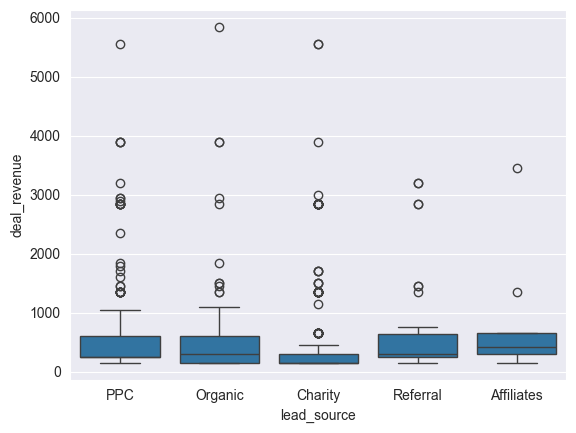

In [39]:
sns.boxplot(data=df_combined, x='lead_source', y='deal_revenue')

In [40]:
df_combined.groupby(["lead_source"]).agg(avg_sales=("deal_revenue", "mean"),count=("lead_source", "size"), total_revenue=("deal_revenue", "sum")).reset_index().sort_values(by=['avg_sales'], ascending=False)

,lead_source,avg_sales,count,total_revenue
0,Affiliates,794.600000,24,7946.0
2,Organic,679.890411,226,49632.0
3,PPC,645.128205,486,125800.0
4,Referral,644.304348,104,29638.0
1,Charity,528.467681,660,138987.0


# Metric Recommendations

Having explored the data we know have a better understanding of Octopus Legacy's sales performance in addition to some key behaviors we'd want to track.

Here are some candidates for Metrics:
- **⭐️ Average Order Value (AOV):**
    - Definition: Average Revenue generated from total line items in an order
    - Why track it? Informs us of the value of transactions over different segments (Lead Source, Customer Segments) and whether any interventions (Such as an AB test) could lift spending per order.
    - Formula: AVG(SUM(line_item_revenue) OVER (PARTITION BY deal_id))

- **⭐️ Deal Conversion Rate (DCR):**
    - Definition: The % of deals which are successfully purchased following document preparation. This is based on volume.
    - Why track it? Helps identify any customer friction around time of purchase and benchmarks consultant performance
    - Formula: COUNT(Successful Deals) / COUNT(Prepared Documents)

- **⭐️ Acquisition Costs (AC):**
    - Definition: The £ needed in order to acquire 1 customer
    - Why track it? Informs us of the value of different marketing channels so that we can better allocate budget
    - Formula: SUM(Marketing & Sales Spend) / COUNT(Number of customers)


### The Long term vision:
- ** North Star Metrics**: We'd want to create a handful of KPIs across departments which inform whether our interventions are benefitting the team.
- **🎄 Metric Tree**: Combine these departmental metrics into a hierarchy. Leading indicators at the bottom of the tree feed into the top. These allow us to see what interventions are making an impact on the business and to what extent.


